<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scann -q

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
import scann
plt.style.use('ggplot')
# import openai
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [4]:
vector_dir = 'drive/MyDrive/BBC_content_vectors.npy'
title_dir = 'drive/MyDrive/transfer/title_vectors_gpt.npy'
embedding_vectors = np.load(vector_dir)
title_gpt_vectors = np.squeeze(np.load(title_dir))
print((embedding_vectors).shape)
print(title_gpt_vectors.shape)

(15468, 1536)
(15468, 1536)


In [5]:
pca_ = PCA(n_components=256, random_state = 42, svd_solver = 'arpack')
embedding_vectors_pca = pca_.fit_transform(embedding_vectors)
title_vectors_pca = pca_.transform(title_gpt_vectors)

In [6]:
searcher = scann.scann_ops_pybind.builder(embedding_vectors, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [7]:
searcher_pca = scann.scann_ops_pybind.builder(embedding_vectors_pca, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

In [8]:
raw_idx = []
reduced_idx = []
for i in range(100):
    raw_idx.append(searcher.search(title_gpt_vectors[i])[0])
    reduced_idx.append(searcher_pca.search(title_vectors_pca[i])[0])

In [9]:
def hit_rate(actual, predicted):
    return np.intersect1d(actual, predicted)

In [10]:
reduced_idx = np.array(reduced_idx, dtype = 'int32')
raw_idx = np.array(raw_idx, dtype = 'int32')

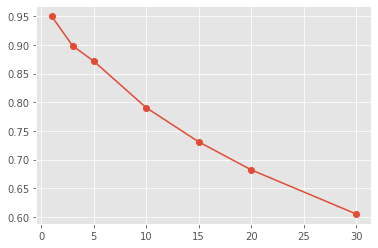

In [11]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    if not actual:
        return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

    
ap_1 = mapk(raw_idx.tolist(), reduced_idx.tolist(),k=1)
ap_3 = mapk(raw_idx.tolist(), reduced_idx.tolist(),k=3)
ap_5 = mapk(raw_idx.tolist(), reduced_idx.tolist(),k=4)
ap_10 = mapk(raw_idx.tolist(), reduced_idx.tolist(),k=10)
ap_15 = mapk(raw_idx.tolist(), reduced_idx.tolist(),k=15)
ap_20 = mapk(raw_idx.tolist(), reduced_idx.tolist(),k=20)
ap_30 = mapk(raw_idx.tolist(), reduced_idx.tolist(),k=30)
plt.plot([1,3,5,10,15,20,30], [ap_1,ap_3,ap_5,ap_10,ap_15,ap_20,ap_30], 'o-')

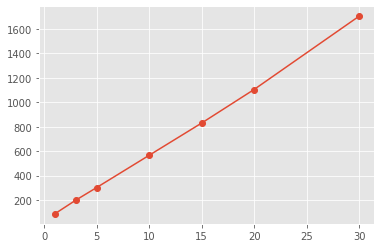

In [12]:
def intersect(actual, predicted,k):
    return np.intersect1d(actual, predicted)

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(raw_idx[i][:k], reduced_idx[i][:k],3)
        total = total + len(intersection)

    return total

HR_1 = hit_rate(raw_idx, reduced_idx, 1)
HR_3 = hit_rate(raw_idx, reduced_idx, 3)
HR_5 = hit_rate(raw_idx, reduced_idx, 5)
HR_10 = hit_rate(raw_idx, reduced_idx, 10)
HR_15 = hit_rate(raw_idx, reduced_idx, 15)
HR_20 = hit_rate(raw_idx, reduced_idx, 20)
HR_30 = hit_rate(raw_idx, reduced_idx, 30)
plt.plot([1,3,5,10,15,20,30], [HR_1,HR_3,HR_5,HR_10,HR_15,HR_20,HR_30], 'o-')

In [13]:
# pca_variance = []
# explained_variance_ratio_= []
# for i in np.arange(2,400,4):
#     pca_ = PCA(n_components=i, random_state = 42)
#     embedding_vectors_pca = pca_.fit_transform(embedding_vectors)
#     pca_variance.append(np.cumsum(pca_.explained_variance_))
#     explained_variance_ratio_.append(np.cumsum(pca_.explained_variance_ratio_))
#     # title_vectors_pca = pca_.transform(title_gpt_vectors)

In [14]:
# summed_explained_variance_ratio_ = []
# for i in range(len(explained_variance_ratio_)):
#     summed_explained_variance_ratio_= np.cumsum(explained_variance_ratio_[i])

In [15]:
# np.cumsum(pca_variance[0])

In [35]:
pca = PCA().fit(embedding_vectors)
pca_var = np.cumsum(pca.explained_variance_ratio_)

svd_content = TruncatedSVD(n_iter= 20, n_components = 1536 ).fit(embedding_vectors)
svd_var = np.cumsum(svd_content.explained_variance_ratio_)

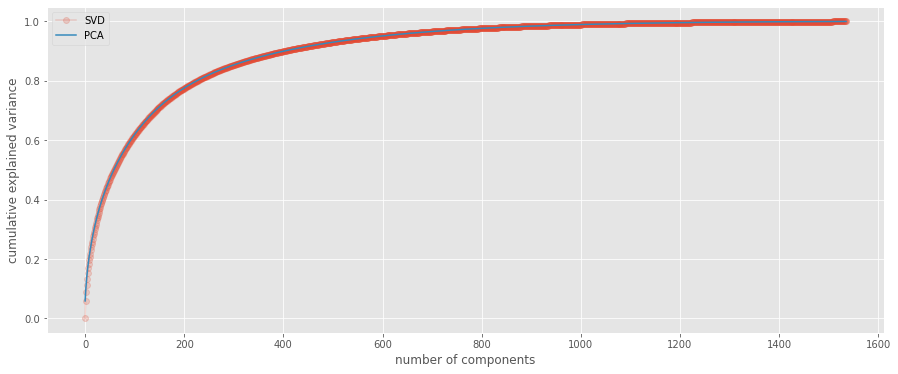

In [36]:
plt.figure(figsize = (15,6))
plt.plot(svd_var, marker = 'o', alpha =0.2)
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

# plt.figure(figsize = (15,6))
plt.plot(pca_var)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.legend(['SVD','PCA'])

In [37]:
print('PCA 100% :',np.where(np.array(pca_var) >= 0.99)[0][0])
print('SVD 100% :',np.where(np.array(svd_var) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var) >= 0.95)[0][0])
print('SVD 95% :',np.where(np.array(svd_var) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var) >= 0.90)[0][0])
print('SVD 90% :',np.where(np.array(svd_var) >= 0.90)[0][0])
print('SVD 95% :',np.where(np.array(svd_var) >= 0.82)[0][0])
print('SVD 90% :',np.where(np.array(svd_var) >= 0.82)[0][0])

PCA 100% : 1007
SVD 100% : 1007
PCA 95% : 593
SVD 95% : 593
PCA 90% : 401
SVD 90% : 402
SVD 95% : 250
SVD 90% : 250


In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
std_sc = StandardScaler()
std_sc.fit(embedding_vectors)
scaled_embedding_vectors = std_sc.transform(embedding_vectors)

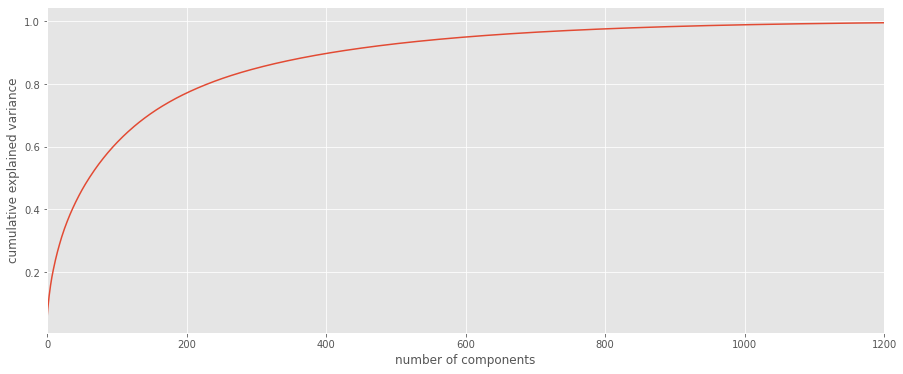

In [21]:
pca = PCA().fit(scaled_embedding_vectors)
pca_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize = (15,6))
plt.plot(pca_var)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.xlim([0,1200]);

In [22]:
np.where(np.array(pca_var) >= 0.95)[0][0]

598

In [23]:
pca_256 = PCA(n_components = 256).fit(embedding_vectors)
pca_256_reduced_content = pca_256.transform(embedding_vectors)
pca_256_reduced_title = pca_256.transform(title_gpt_vectors)

In [24]:
pca_593 = PCA(n_components = 593).fit(embedding_vectors)
pca_593_reduced_content = pca_593.transform(embedding_vectors)
pca_593_reduced_title = pca_593.transform(title_gpt_vectors)

In [25]:
pca_1007 = PCA(n_components = 1007).fit(embedding_vectors)
pca_1007_reduced_content = pca_1007.transform(embedding_vectors)
pca_1007_reduced_title = pca_1007.transform(title_gpt_vectors)

In [26]:
np.save('./pca_256_reduced_content.npy',pca_256_reduced_content)
np.save('./pca_256_reduced_title.npy',pca_256_reduced_title)

In [27]:
np.save('./pca_593_reduced_content.npy',pca_593_reduced_content)
np.save('./pca_593_reduced_title.npy',pca_593_reduced_title)

In [28]:
np.save('./pca_1007_reduced_content.npy',pca_1007_reduced_content)
np.save('./pca_1007_reduced_title.npy',pca_1007_reduced_title)